In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from scipy.stats import skew


%config InlineBackend.figure_format = 'retina'
%matplotlib notebook

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Save column Id
train_id = train['Id']
test_id = test['Id']

# Drop column Id because it's useless for the process
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

train_num = train.select_dtypes(exclude=['object'])
train_num.fillna(0,inplace=True)
print(len(train_num))

test.fillna(0,inplace=True)

1460


In [4]:
train_cat = train.select_dtypes(exclude=['int64', 'float64'])
train_num.fillna('None',inplace=True)
print(len(train_num))
train_cat.head(10)


1460


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
5,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,Shed,WD,Normal
6,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
7,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,...,Attchd,RFn,TA,TA,Y,NaN,NaN,Shed,WD,Normal
8,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,...,Detchd,Unf,Fa,TA,Y,NaN,NaN,NaN,WD,Abnorml
9,RL,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,...,Attchd,RFn,Gd,TA,Y,NaN,NaN,NaN,WD,Normal


In [5]:
for dataset in train_num, test:
    dataset['Surface'] = dataset['GrLivArea'] + dataset['TotalBsmtSF']

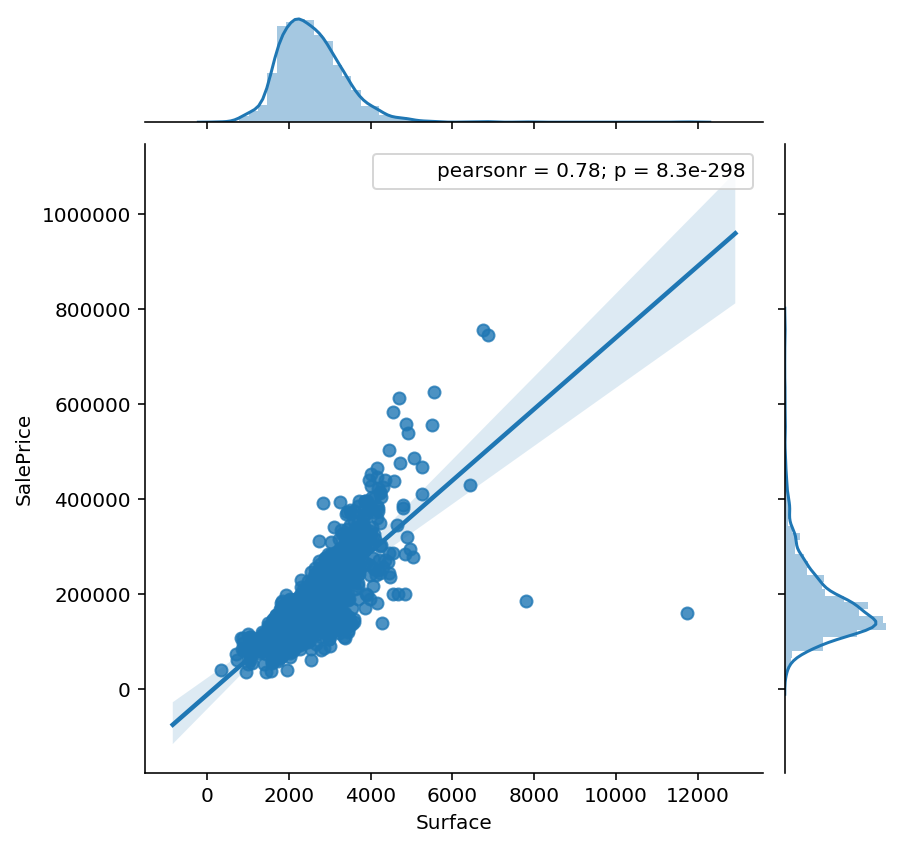

In [6]:
sns.jointplot(x=train_num['Surface'], y = train_num['SalePrice'], kind='reg').annotate(pearsonr)

Remove outliers

In [7]:
clf = IsolationForest(max_samples = 100, random_state=42)
clf.fit(train_num)
y_not_outlier = clf.predict(train_num)
y_not_outlier = pd.DataFrame(y_not_outlier, columns = ['Outlier'])

y_not_outlier[y_not_outlier['Outlier'] == 1].index.values
y_not_outlier.head(10)

print(len(train))

#train.head(10)

1460


In [8]:
train_num = train_num.iloc[y_not_outlier[y_not_outlier['Outlier'] == 1].index.values]
train_num.reset_index(drop = True, inplace = True)

In [9]:
print(len(train_num))

1314


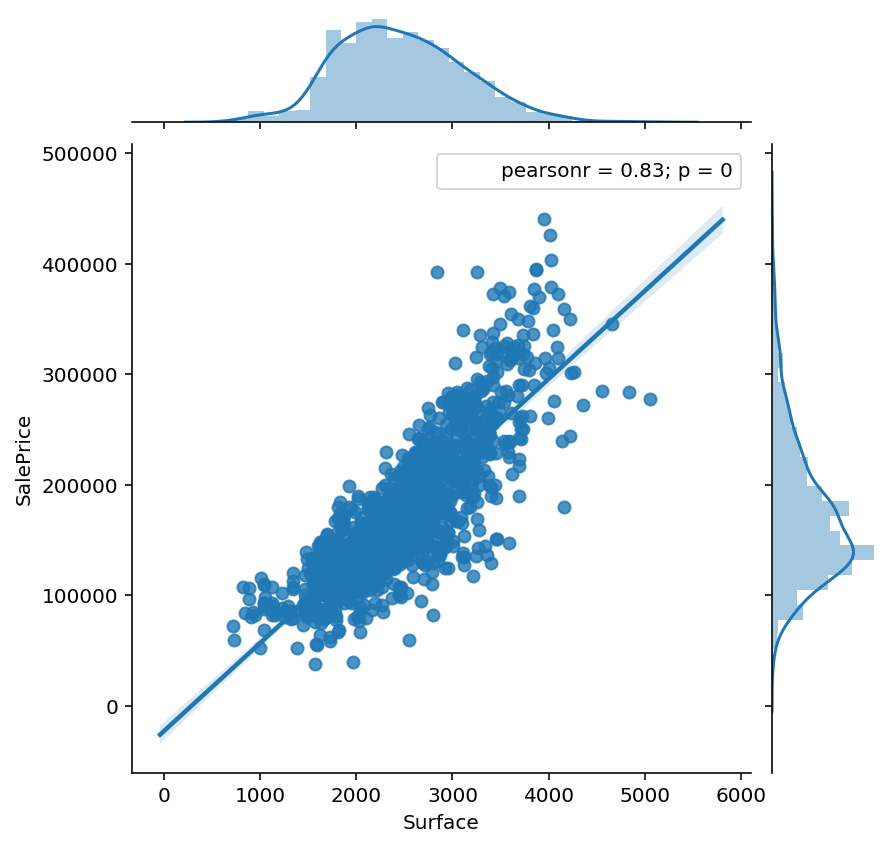

In [10]:
sns.jointplot(x=train_num['Surface'], y = train_num['SalePrice'], kind='reg').annotate(pearsonr)

In [11]:
train = train_num.join(train_cat)
train.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [12]:
train.shape

(1314, 81)

In [13]:

# Combining Datasets
rows_train = train.shape[0]
rows_test = test.shape[0]

y_train = train.SalePrice.values

combined = pd.concat((train, test)).reset_index(drop = True)
combined.drop(['SalePrice'], axis=1, inplace=True)
combined.shape

print(f"Train dataset size: {train.shape}")
print(f"Test dataset size: {test.shape}")
print(f"Combined dataset(train + test) size: {combined.shape}")

Train dataset size: (1314, 81)
Test dataset size: (1459, 80)
Combined dataset(train + test) size: (2773, 80)


In [14]:
num_features = combined.dtypes[combined.dtypes != "object"].index

# Check the skew of all numerical features
skewed_features = combined[num_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewness' :skewed_features})
skewness.head(10)

,Skewness
MiscVal,23.652164
PoolArea,20.677791
LowQualFinSF,14.880653
3SsnPorch,11.241921
LotArea,5.721671
KitchenAbvGr,4.716559
BsmtFinSF2,4.236703
EnclosedPorch,4.097652
BsmtHalfBath,4.056239
ScreenPorch,3.971352


In [15]:
#skewness = skewness[abs(skewness) > 0.5]
#print(f"There are {skewness.shape[0]} skewed numerical features")

In [16]:
print(combined.shape)

(2773, 80)


In [17]:
combined = pd.get_dummies(combined)
print(combined.shape)

(2773, 309)


In [18]:
train = combined[:rows_train]
test = combined[rows_train:]

One hot Encoding

In [19]:
train['SalePrice'] = y_train
Y = train['SalePrice']

In [20]:
target = 'SalePrice'

X_train, X_val, y_train, y_val = train_test_split(train, Y, test_size=0.3, random_state=42)
X_train = X_train.drop(target, axis=1)
X_val = X_val.drop(target, axis=1)

In [21]:
xgbr = xgb.XGBRegressor()

In [22]:
X_train.shape

(919, 309)

In [23]:
y_train.shape

(919,)

In [24]:
xgbr.fit(X_train, y_train)

[14:21:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [25]:
scores_xgbr = cross_val_score(xgbr, X_train, y_train, cv=5)
print("Mean cross-validation score XGBoost: %.2f" % scores_xgbr.mean())

[14:21:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean cross-validation score XGBoost: 0.89


In [26]:
y_pred_xgbr = xgbr.predict(X_val)
mse_xgbr = mean_squared_error(y_val, y_pred_xgbr)
print("MSE XGBR: %.4f" % mse_xgbr)
print("RMSE XGBR: %.4f" % np.sqrt(mse_xgbr))

MSE XGBR: 430935080.7247
RMSE XGBR: 20758.9759


In [27]:
mae_xgbr = mean_absolute_error(y_val, y_pred_xgbr)
print("MAE XGBR: %.4f" % mae_xgbr)


MAE XGBR: 14298.7714


In [28]:
msle_xgbr = mean_squared_log_error(y_val, y_pred_xgbr)
print("MSLE XGBR: %.4f" % msle_xgbr)

MSLE XGBR: 0.0143


In [29]:
y_kaggle_xgbr = xgbr.predict(test)

import kaggle

kaggle_feats = {'Id':test_id, 'SalePrice':y_kaggle_xgbr}
sub = pd.DataFrame(data=kaggle_feats)
sub.to_csv('submission_xgbr.csv', index=False)

submission_file = 'submission_xgbr.csv'
kaggle.api.competition_submit(submission_file, "Submission XGBR)", "house-prices-advanced-regression-techniques")

100%|██████████| 21.2k/21.2k [00:04<00:00, 4.64kB/s]


Successfully submitted to House Prices: Advanced Regression Techniques

In [30]:
kaggle.api.competitions_submissions_list("house-prices-advanced-regression-techniques")

[{'ref': 13585547,
  'totalBytes': 21673,
  'date': '2019-12-02T14:18:03.64Z',
  'description': 'Submission KRR)',
  'errorDescription': None,
  'fileName': 'submission_krr.csv',
  'publicScore': None,
  'privateScore': None,
  'status': 'pending',
  'submittedBy': 'Bastien Roques',
  'submittedByRef': 'broques',
  'teamName': 'Bastien Roques',
  'type': 'standard',
  'url': 'https://www.kaggle.com/submissions/13585547/13585547.raw'},
 {'ref': 13567695,
  'totalBytes': 21723,
  'date': '2019-12-01T08:32:59.577Z',
  'description': 'Submission Keras',
  'errorDescription': None,
  'fileName': 'submission_keras.csv',
  'publicScore': '0.17190',
  'privateScore': None,
  'status': 'complete',
  'submittedBy': 'Bastien Roques',
  'submittedByRef': 'broques',
  'teamName': 'Bastien Roques',
  'type': 'standard',
  'url': 'https://www.kaggle.com/submissions/13567695/13567695.raw'},
 {'ref': 13561788,
  'totalBytes': 21624,
  'date': '2019-11-30T20:29:17.343Z',
  'description': 'Submission Ker